In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import nengo
from numpy.random import uniform as np_uni
from nengo.dists import Uniform
from nengo.utils.ensemble import tuning_curves
from nengo.processes import Piecewise

model = nengo.Network('Eye Control System')

with model:
    tau = 0.1
    slow_path_tau = 0.2
    tau_timer = 0.12
    tau_fovea = 0.02
    N = 200
    muscle_strength = 0.25
    amp_lr = 0.003
    SACCADE_TIME_BOUND = [3, 6]
    POS_RANGE = [-1, 1]

    class V1_signal_generator:
        def __init__(self):
            # variables used by pos
            self.next_saccade = 0.1
            self.in_saccade = False
            self.saccade_target = [0, 0]
            self.last_saccade = 0
            self.signals = 0

        # generate random target position signal with respect to time
        def pos(self, t):
            if self.in_saccade:
                if t > self.last_saccade + 0.1:
                    self.in_saccade = False
                return self.saccade_target

            if t > self.next_saccade:
                self.saccade_target = np_uni(POS_RANGE[0], POS_RANGE[1], 2)
                self.next_saccade = np_uni(SACCADE_TIME_BOUND[0], SACCADE_TIME_BOUND[1]) + t
                self.in_saccade = True
                self.last_saccade = t
                return self.saccade_target

            return [0, 0]

        def expected_pos(self, t):
            return self.saccade_target

        def saccade_now(self):
            return self.in_saccade
    
    V1_signal = V1_signal_generator()
    # stimulus from V1
    V1 = nengo.Node(lambda t: V1_signal.pos(t))
    # use -10 to make sure strong and quick inhibition signal
    vi_cortex_gating = nengo.Node(lambda t: 0 if V1_signal.saccade_now() else -10)
    # expected fovea position
    fovea_expect = nengo.Node(lambda t: V1_signal.expected_pos(t))
    
    vi_cortex_h = nengo.Ensemble(N, dimensions=1)
    vi_cortex_v = nengo.Ensemble(N, dimensions=1)
    ocu_motor_nu = nengo.Ensemble(N, dimensions=2)
    timer = nengo.Ensemble(N, dimensions=1)
    inhib = nengo.Ensemble(N, dimensions=1)
    mr_v = nengo.Ensemble(N, dimensions=1)
    lr_v = nengo.Ensemble(N, dimensions=1)
    sr_v = nengo.Ensemble(N, dimensions=1)
    ir_v = nengo.Ensemble(N, dimensions=1)
    h_v_coor = nengo.Ensemble(N, dimensions=1)
    v_v_coor = nengo.Ensemble(N, dimensions=1)
    fovea = nengo.Ensemble(N, dimensions=2)
    retinal_drift_error = nengo.Ensemble(N, dimensions=2)
    error_amp_h = nengo.Ensemble(N, dimensions=1)
    error_amp_v = nengo.Ensemble(N, dimensions=1)
    fixation_gating = nengo.Ensemble(N, dimensions=1)
    
    def timer_decay(x): # linear decay
        return x - tau_timer if x > 0 else 0
    
    def integrate_feedback(x): # integrator
        return 1 * x
    
    def fovea_int_with_drift(x): # integrator for fovea but with a decay constant
        return [x[0] - (tau_fovea if x[0] > 0 else -tau_fovea),
                x[1] - (tau_fovea if x[1] > 0 else -tau_fovea)]
    
    # calculate distance
    nengo.Connection(V1[0], vi_cortex_h)
    nengo.Connection(fovea[0], vi_cortex_h, transform=-1)
    nengo.Connection(V1[1], vi_cortex_v)
    nengo.Connection(fovea[1], vi_cortex_v, transform=-1)
    # transmitting distance to oculomotor neucleus
    nengo.Connection(vi_cortex_h, ocu_motor_nu[0])
    nengo.Connection(vi_cortex_v, ocu_motor_nu[1])
    # generate gating signal
    nengo.Connection(vi_cortex_gating, vi_cortex_h.neurons, function=lambda inhib: [inhib] * N)
    nengo.Connection(vi_cortex_gating, vi_cortex_v.neurons, function=lambda inhib: [inhib] * N)
    # start up velocity coordinators
    nengo.Connection(ocu_motor_nu, h_v_coor, function=lambda x: x[0] / (0.001 + sqrt(x[0]**2 + x[1]**2)), synapse=0.1)
    nengo.Connection(ocu_motor_nu, v_v_coor, function=lambda x: x[1] / (0.001 + sqrt(x[0]**2 + x[1]**2)), synapse=0.1)
    # feedback to maintin velocity coordinator activity
    nengo.Connection(h_v_coor, h_v_coor, function=integrate_feedback, synapse=0.05)
    nengo.Connection(v_v_coor, v_v_coor, function=integrate_feedback, synapse=0.05)
    # start up the timer
    nengo.Connection(ocu_motor_nu, timer, function=lambda x: sqrt(x[0]**2 + x[1]**2), synapse=0.001)
    # timer decay
    nengo.Connection(timer, timer, function=timer_decay, synapse=tau)
    # timer to gating signal
    nengo.Connection(timer, inhib, function=lambda c: -10 if c < 0.1 else 10, synapse=0.001)
    # gating inhibition signal to velocity coordinators
    nengo.Connection(inhib, h_v_coor.neurons, function=lambda inhib: [-10 if inhib < 0 else 0] * N)
    nengo.Connection(inhib, v_v_coor.neurons, function=lambda inhib: [-10 if inhib < 0 else 0] * N)
    # coordinator to component muscles
    nengo.Connection(h_v_coor, mr_v, function=lambda x: x if x > 0 else 0)
    nengo.Connection(h_v_coor, lr_v, function=lambda x: -x if x < 0 else 0)
    nengo.Connection(v_v_coor, sr_v, function=lambda x: x if x > 0 else 0)
    nengo.Connection(v_v_coor, ir_v, function=lambda x: -x if x < 0 else 0)
    # muscules to fovea
    nengo.Connection(mr_v, fovea[0], transform=muscle_strength, synapse=0.005)
    nengo.Connection(lr_v, fovea[0], transform=-muscle_strength, synapse=0.005)
    nengo.Connection(sr_v, fovea[1], transform=muscle_strength, synapse=0.005)
    nengo.Connection(ir_v, fovea[1], transform=-muscle_strength, synapse=0.005)
    # fovea back to itself to simulate integration
    nengo.Connection(fovea, fovea, function=fovea_int_with_drift, synapse=tau)
    # retinal drift error
    nengo.Connection(fovea_expect, retinal_drift_error, transform=-1, synapse=0.005)
    nengo.Connection(fovea, retinal_drift_error, synapse=0.005)
    # learning error amplifier
    amp_h_conn = nengo.Connection(retinal_drift_error[0], error_amp_h, synapse=0.005)
    amp_h_conn.learning_rule_type = nengo.PES(learning_rate=amp_lr)
    amp_h_learn = nengo.Connection(retinal_drift_error[0], amp_h_conn.learning_rule)
    amp_v_conn = nengo.Connection(retinal_drift_error[1], error_amp_v, synapse=0.005)
    amp_v_conn.learning_rule_type = nengo.PES(learning_rate=amp_lr)
    amp_v_learn = nengo.Connection(retinal_drift_error[1], amp_v_conn.learning_rule)
    # amplifier to muscle signal
    nengo.Connection(error_amp_h, mr_v, function=lambda x: x if x > 0 else 0, synapse=0.005)
    nengo.Connection(error_amp_h, lr_v, function=lambda x: -x if x < 0 else 0, synapse=0.005)
    nengo.Connection(error_amp_v, sr_v, function=lambda x: x if x > 0 else 0, synapse=0.005)
    nengo.Connection(error_amp_v, ir_v, function=lambda x: -x if x < 0 else 0, synapse=0.005)
    # propagate error signal based on fixation gating
    nengo.Connection(fixation_gating, retinal_drift_error.neurons, function=lambda inhib: [-10 if inhib < 0 else 0] * N, synapse=0.005)
    # inverse gating
    nengo.Connection(inhib, fixation_gating, function=lambda inhib: 10 if inhib < -0.1 else -10)
    
    # probes
    v1_p = nengo.Probe(V1, synapse=.01)
    inhib_p = nengo.Probe(inhib, synapse=.01)
    ocu_p = nengo.Probe(ocu_motor_nu, synapse=.01)
    timer_p = nengo.Probe(timer, synapse=.01)
    mr_v_p = nengo.Probe(mr_v, synapse=.01)
    lr_v_p = nengo.Probe(lr_v, synapse=.01)
    sr_v_p = nengo.Probe(sr_v, synapse=.01)
    ir_v_p = nengo.Probe(ir_v, synapse=.01)
    fovea_p = nengo.Probe(fovea, synapse=.01)
    drift_error_p = nengo.Probe(retinal_drift_error, synapse=.01)
    fovea_expect_p = nengo.Probe(fovea_expect, synapse=.01)
    fixation_gate_p = nengo.Probe(fixation_gating, synapse=.01)

Populating the interactive namespace from numpy and matplotlib


In [2]:
class nengo_data:
    def __init__(self, simdata):
        self.fovea_p = simdata[fovea_p]
        self.drift_error_p = simdata[drift_error_p]
        self.fovea_expect_p = simdata[fovea_expect_p]

In [3]:
import dill

for i in range(5):
    sim = nengo.Simulator(model)
    sim.run(30.)
    with open('result/sim_data_probe_200' + str(i), 'wb') as f:
        dill.dump(nengo_data(sim.data), f)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

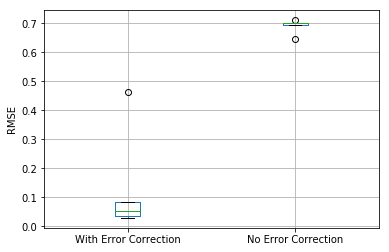

In [8]:
import dill
import pandas as pd

normal_series = []
for i in range(5):
    sim_data = None
    with open('result/sim_data_probe' + str(i), 'rb') as f:
        sim_data = dill.load(f)
    rmse_normal = np.sqrt(np.average((sim_data.fovea_p - sim_data.fovea_expect_p)**2))
    
    with open('result/sim_data_probe_c' + str(i), 'rb') as f:
        sim_data = dill.load(f)
    rmse_compare = np.sqrt(np.average((sim_data.fovea_p - sim_data.fovea_expect_p)**2))
    normal_series.append([rmse_normal, rmse_compare])
    
df = pd.DataFrame(normal_series, columns=['With Error Correction', 'No Error Correction'])
df.boxplot(column=['With Error Correction', 'No Error Correction'])
ylabel('RMSE')

savefig('ec.png')

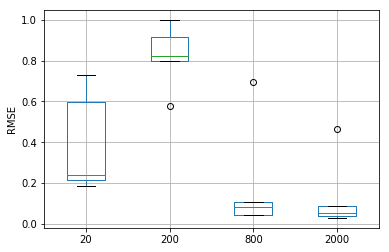

In [4]:
import dill
import pandas as pd

normal_series = []
for i in range(5):
    sim_data = None
    sub_series = []
    for nn in ['20', '200', '800']:
        with open('result/sim_data_probe_' + nn + str(i), 'rb') as f:
            sim_data = dill.load(f)
        rmse = np.sqrt(np.average((sim_data.fovea_p - sim_data.fovea_expect_p)**2))
        sub_series.append(rmse)
    
    with open('result/sim_data_probe' + str(i), 'rb') as f:
        sim_data = dill.load(f)
    rmse = np.sqrt(np.average((sim_data.fovea_p - sim_data.fovea_expect_p)**2))
    sub_series.append(rmse)
    
    normal_series.append(sub_series)
    
df = pd.DataFrame(normal_series, columns=['20', '200', '800', '2000'])
df.boxplot(column=['20', '200', '800', '2000'])
ylabel('RMSE')

savefig('nn.png')

In [ ]:
import dill
import pandas as pd

normal_series = []
for i in range(5):
    sim_data = None
    with open('result/sim_data_probe' + str(i), 'rb') as f:
        sim_data = dill.load(f)
    rmse_normal = np.sqrt(np.average((sim_data.fovea_p - sim_data.fovea_expect_p)**2))
    
    with open('result/sim_data_probe_c' + str(i), 'rb') as f:
        sim_data = dill.load(f)
    rmse_compare = np.sqrt(np.average((sim_data.fovea_p - sim_data.fovea_expect_p)**2))
    normal_series.append([rmse_normal, rmse_compare])
    
df = pd.DataFrame(normal_series, columns=['With Error Correction', 'No Error Correction'])
df.boxplot(column=['With Error Correction', 'No Error Correction'])
ylabel('RMSE')

savefig('ec.png')

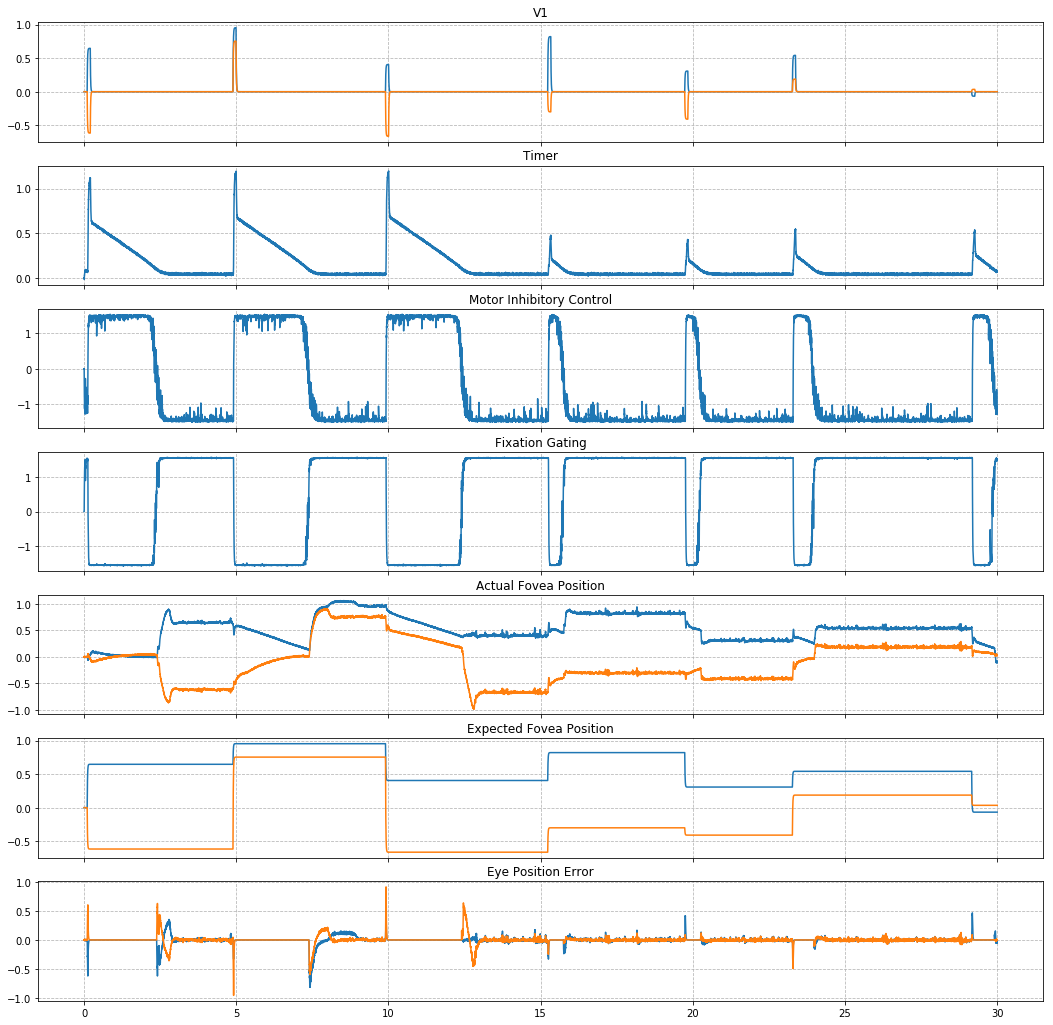

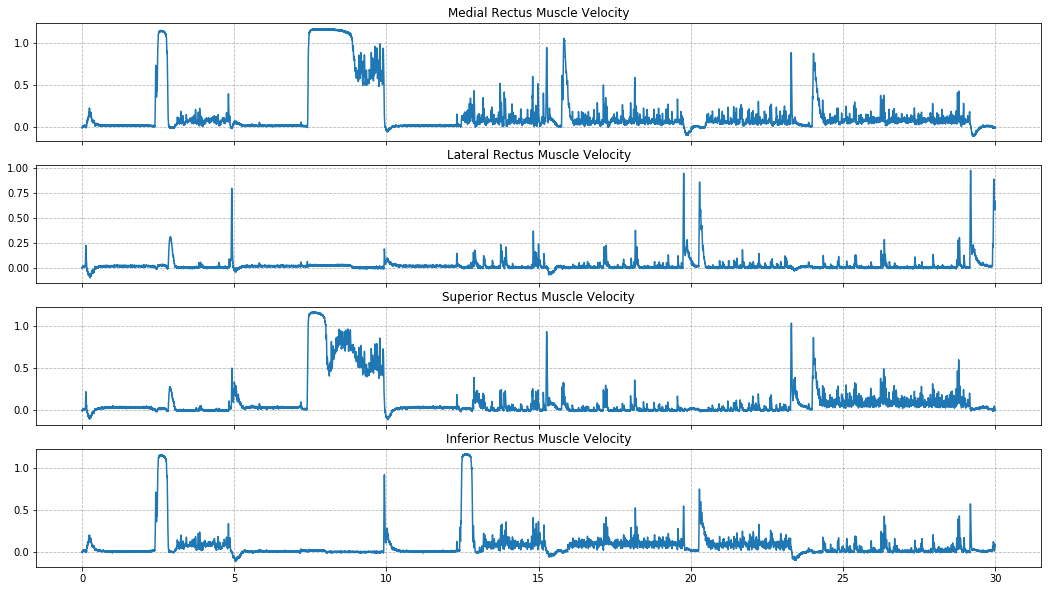

In [20]:
f, axarr = plt.subplots(7, 1, sharex=True)

f.set_figheight(18)
f.set_figwidth(18)

axarr[0].set_title('V1');
axarr[0].plot(sim.trange(), sim.data[v1_p]);
axarr[0].grid(alpha=0.9, linestyle='--')

axarr[1].set_title('Timer');
axarr[1].plot(sim.trange(), sim.data[timer_p]);
axarr[1].grid(alpha=0.9, linestyle='--')

axarr[2].set_title('Motor Inhibitory Control');
axarr[2].plot(sim.trange(), sim.data[inhib_p]);
axarr[2].grid(alpha=0.9, linestyle='--')

axarr[3].set_title('Fixation Gating');
axarr[3].plot(sim.trange(), sim.data[fixation_gate_p]);
axarr[3].grid(alpha=0.9, linestyle='--')

axarr[4].set_title('Actual Fovea Position');
axarr[4].plot(sim.trange(), sim.data[fovea_p]);
axarr[4].grid(alpha=0.9, linestyle='--')

axarr[5].set_title('Expected Fovea Position');
axarr[5].plot(sim.trange(), sim.data[fovea_expect_p]);
axarr[5].grid(alpha=0.9, linestyle='--')

axarr[6].set_title('Eye Position Error');
axarr[6].plot(sim.trange(), sim.data[drift_error_p]);
axarr[6].grid(alpha=0.9, linestyle='--')

savefig('example1.png')

f, axarr = plt.subplots(4, 1, sharex=True)

f.set_figheight(10)
f.set_figwidth(18)

axarr[0].set_title('Medial Rectus Muscle Velocity');
axarr[0].plot(sim.trange(), sim.data[mr_v_p]);
axarr[0].grid(alpha=0.9, linestyle='--')

axarr[1].set_title('Lateral Rectus Muscle Velocity');
axarr[1].plot(sim.trange(), sim.data[lr_v_p]);
axarr[1].grid(alpha=0.9, linestyle='--')

axarr[2].set_title('Superior Rectus Muscle Velocity');
axarr[2].plot(sim.trange(), sim.data[sr_v_p]);
axarr[2].grid(alpha=0.9, linestyle='--')

axarr[3].set_title('Inferior Rectus Muscle Velocity');
axarr[3].plot(sim.trange(), sim.data[ir_v_p]);
axarr[3].grid(alpha=0.9, linestyle='--')

savefig('example2.png')

In [2]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "layout.svg")

In [4]:
%pylab
import numpy
import nengo
from nengo.utils.ensemble import tuning_curves
from nengo.dists import Uniform

N = 2000

model = nengo.Network(label='Neurons')
with model:
    neurons = nengo.Ensemble(N, dimensions=1)

    connection = nengo.Connection(neurons, neurons) #reg=0 means ignore noise
    
sim = nengo.Simulator(model)

d = sim.data[connection].weights.T

x, A = tuning_curves(neurons, sim)

xhat = numpy.dot(A, d)

plot(x, A);
xlabel('x');
ylabel('firing rate (Hz)');

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

* Eye control is very complicated, I am only simulating a small part of the eye control.
* Issues with current model and possible future plan
    - Use learning to get fovea to the exact position
    - Use learning to learn retinal slip

## Eye movements:
### Saccade: ![Saccade](saccade.jpg)
### Pursuit: ![Pursuit](pursuit.jpg)

* We are interested in saccade
    - Integration can be thought of a physical consequence giving the speed already computed.
    - We interested in how to compute these velocity function which has the square wave shape:
    ![SC](sc.png)
    - Using decay to create a timer, use inhibit group of neuron to create sharp square wave.